# Old, based on all pairs

In [1]:
import pandas as pd
import wget
import os

# Top gene_snp pairs

In [143]:
top_pairs=pd.read_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/gene_variant_selection.csv',names=['gene_id', 'variant_id', 'rsid'],skiprows=1)


In [146]:
top_pairs['variant_id']=top_pairs['variant_id'].str.rstrip('_b38')

In [150]:
top_pairs

,gene_id,variant_id,rsid
0,ENSG00000187961,chr1_951408_G_A,rs10465242
1,ENSG00000187961,chr1_965350_G_A,rs3935066
2,ENSG00000187961,chr1_966179_G_A,rs13303160
3,ENSG00000197785,chr1_1175206_T_C,rs9442387
4,ENSG00000160072,chr1_1177351_G_A,rs186127282
...,...,...,...
185358,ENSG00000277203,chrX_155758623_T_C,rs113469966
185359,ENSG00000277203,chrX_155758735_C_G,rs6655071
185360,ENSG00000277203,chrX_155758971_T_C,rs57915757
185361,ENSG00000277203,chrX_155759226_G_A,rs58248838


In [161]:
top_pairs[(top_pairs['rsid'] == 'rs59512422') & (top_pairs['gene_id']=='ENSG00000169612')]

,gene_id,variant_id,rsid
43640,ENSG00000169612,chr15_82909508_G_A,rs59512422
43641,ENSG00000169612,chr15_82909508_G_C,rs59512422


# eQTL Catalogue data download

In [2]:
wd='/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/'

In [3]:
catalogue_exp=pd.read_csv(wd+'tabix_ftp_paths.tsv',sep='\t')

In [6]:
catalogue_exp.ftp_path[0]

'ftp://ftp.ebi.ac.uk/pub/databases/spot/eQTL/csv/Alasoo_2018/ge/Alasoo_2018_ge_macrophage_naive.all.tsv.gz'

In [186]:
# catalogue_exp[(catalogue_exp['quant_method'] == 'ge') & (catalogue_exp['condition_label'] == 'naive')].to_csv(wd+'filtered.csv',index=False,sep='\t')

In [187]:
filtered_catalogue_exp=catalogue_exp[catalogue_exp['condition_label'] == 'naive'].groupby(['study','tissue_ontology_id']).first()

In [188]:
filtered_catalogue_exp.to_csv(wd+'filtered.csv',index=False,sep='\t')

In [189]:
len(filtered_catalogue_exp['tissue_ontology_term'])

46

In [192]:
filtered_catalogue_exp['ftp_path'][0]

'ftp://ftp.ebi.ac.uk/pub/databases/spot/eQTL/csv/Alasoo_2018/ge/Alasoo_2018_ge_macrophage_naive.all.tsv.gz'

In [18]:
for index in filtered_catalogue_exp.index:
    url=filtered_catalogue_exp.loc[index]['ftp_path']
    output=wd+'eqtls/'+filtered_catalogue_exp.loc[index].name[0]+'-'+filtered_catalogue_exp.loc[index]['qtl_group']+'.csv.gz'
    if os.path.exists(output):
        print('Tissue file already exists',output)
        continue
    else:
        try: 
            wget.download(url,output)
            print('Tissue downloaded:', output)
        except: print('Could not download', url)

Tissue downloaded: /nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/eqtls/Alasoo_2018-macrophage_naive.csv.gz
Tissue downloaded: /nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/eqtls/BLUEPRINT-T-cell.csv.gz
Tissue file already exists /nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/eqtls/BLUEPRINT-neutrophil.csv.gz
Tissue file already exists /nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/eqtls/BLUEPRINT-monocyte.csv.gz
Tissue file already exists /nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/eqtls/BrainSeq-brain.csv.gz
Tissue file already exists /nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/eqtls/CEDAR-platelet.csv.gz
Tissue file already exists /nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/original-data/eQTL_catalogue/eqtls/CEDAR-B-cell_CD19.csv.gz
Tissue file already exists /nfs/res

# eQTL Catalogue filtering

In [100]:
for file in os.listdir(wd+'eqtls/'):
    exp_tissue=file.rstrip('.csv.gz')
    if os.path.exists('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/eQTL_catalogue/'+file):
        print(exp_tissue,'already found, skipping.')
        continue
    print(exp_tissue)
    eqt_file=pd.DataFrame()
    names=['variant_id', 'type', 'rsid', 'ref', 'r2', 'pvalue', 'position','molecular_trait_object_id', 'molecular_trait_id', 'median_tpm', 'maf','gene_id', 'chromosome', exp_tissue, 'an', 'alt', 'ac']
    try:
        for chunk in pd.read_csv(wd+'eqtls/'+file,compression='gzip',chunksize=50000,sep='\t',names=names,usecols=['variant_id','rsid','gene_id',exp_tissue],skiprows=1):
            eqt_file=pd.concat([eqt_file,chunk.merge(top_pairs[['gene_id','rsid']])])
    except:
        for chunk in pd.read_csv(wd+'eqtls/'+file,compression='gzip',chunksize=50000,sep='\t',usecols=['variant','rsid','gene_id','beta']):
            chunk=chunk.rename(columns={'variant':'variant_id','beta':exp_tissue})
            eqt_file=pd.concat([eqt_file,chunk.merge(top_pairs[['gene_id','rsid']])])
    eqt_file.to_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/eQTL_catalogue/'+file,index=False,compression='gzip')
    

CEDAR-transverse_colon already found, skipping.
BLUEPRINT-neutrophil already found, skipping.
BLUEPRINT-monocyte already found, skipping.
BrainSeq-brain already found, skipping.
CEDAR-platelet already found, skipping.
CEDAR-B-cell_CD19 already found, skipping.
CEDAR-T-cell_CD4 already found, skipping.
CEDAR-T-cell_CD8 already found, skipping.
CEDAR-neutrophil_CD15 already found, skipping.
CEDAR-monocyte_CD14 already found, skipping.
CEDAR-rectum already found, skipping.
Fairfax_2012-B-cell_CD19 already found, skipping.
CEDAR-ileum already found, skipping.
Naranbhai_2015-neutrophil_CD16 already found, skipping.
Fairfax_2014-monocyte_naive already found, skipping.
GENCORD-fibroblast already found, skipping.
GENCORD-T-cell already found, skipping.
GENCORD-LCL already found, skipping.
GEUVADIS-LCL already found, skipping.
HipSci-iPSC already found, skipping.
Kasela_2017-T-cell_CD4 already found, skipping.
Kasela_2017-T-cell_CD8 already found, skipping.
Lepik_2017-blood already found, skipp

In [169]:
folder='/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/eQTL_catalogue/'
data=pd.DataFrame()
for i in os.listdir(folder):
    eqt_file=pd.read_csv(folder+i)
    if eqt_file[['variant_id','rsid','gene_id']].duplicated().sum() > 100:
        continue
    eqt_file=top_pairs.merge(eqt_file,how='left')
    if data.empty:
         data=eqt_file
    else:
         data=data.merge(eqt_file)
#     print(i,len(top_pairs.merge(pd.read_csv(folder+i,usecols=[1,2,3]),how='left')))
#     eqt_file=top_pairs.merge(pd.read_csv(folder+i,usecols=[1,2,3]),how='left').iloc[:,2]
    #eqt_file=pd.read_csv(folder+i,index_col=['rsid','gene_id'],usecols=[1,2,3]).merge(top_pairs.set_index(['gene_id','rsid']),left_index=True,right_index=True)
#     pd.concat([data,eqt_file],axis=1,sort=False)
#     data=data.merge(eqt_file,how='outer')

In [197]:
data

,gene_id,variant_id,rsid,Alasoo_2018-macrophage_naive,BLUEPRINT-monocyte,BLUEPRINT-neutrophil,BLUEPRINT-T-cell,BrainSeq-brain,GENCORD-fibroblast,GENCORD-LCL,...,Schmiedel_2018-Th17_memory,Schmiedel_2018-Th2_memory,Schmiedel_2018-Treg_memory,Schmiedel_2018-Treg_naive,Schwartzentruber_2018-sensory_neuron,TwinsUK-blood,TwinsUK-fat,TwinsUK-LCL,TwinsUK-skin,van_de_Bunt_2015-pancreatic_islet
0,ENSG00000187961,chr1_951408_G_A,rs10465242,0.186352,0.193578,0.090991,0.095369,NaN,0.005232,0.051359,...,0.097942,0.132538,0.124233,0.160782,0.055735,NaN,NaN,NaN,NaN,0.138826
1,ENSG00000187961,chr1_965350_G_A,rs3935066,0.192737,NaN,NaN,NaN,NaN,0.006569,0.049201,...,0.097401,0.120339,0.120648,0.151342,0.086161,NaN,NaN,NaN,NaN,0.129439
2,ENSG00000187961,chr1_966179_G_A,rs13303160,0.179885,0.195851,0.133773,0.115273,NaN,0.016800,0.053310,...,0.111890,0.128769,0.126183,0.163547,0.063557,NaN,NaN,NaN,NaN,0.129886
3,ENSG00000197785,chr1_1175206_T_C,rs9442387,NaN,-0.028209,NaN,-0.008608,NaN,0.003039,-0.013691,...,0.095865,0.051352,-0.002725,0.006079,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000160072,chr1_1177351_G_A,rs186127282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.108480,-0.970287,-1.214410,-1.098090,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189471,ENSG00000277203,chrX_155758623_T_C,rs113469966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189472,ENSG00000277203,chrX_155758735_C_G,rs6655071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189473,ENSG00000277203,chrX_155758971_T_C,rs57915757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189474,ENSG00000277203,chrX_155759226_G_A,rs58248838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
data.to_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/eqtl_catalogue.csv',index=False)

# Data correlation

In [341]:
corr_eqtlcatalogue=data.corr()

In [176]:
corr_eqtlcatalogue.to_csv('/nfs/research1/zerbino/jhidalgo/inteql_GTEX_v8/data/processed_data/eqtl_catalogue_corr.csv')

In [342]:
newcol=pd.Series(corr_eqtlcatalogue.index.str.split('-',1,expand=True).to_frame().iloc[:,1].values).str.replace('_naive','').str.replace('_memory','').to_list()

In [352]:
tissuedict=dict(zip(corr_eqtlcatalogue.index,newcol))

In [338]:
# corr_eqtlcatalogue.insert(0,'Tissue',newcol)

In [355]:
corr_eqtlcatalogue

,Alasoo_2018-macrophage_naive,BLUEPRINT-monocyte,BLUEPRINT-neutrophil,BLUEPRINT-T-cell,BrainSeq-brain,GENCORD-fibroblast,GENCORD-LCL,GENCORD-T-cell,GEUVADIS-LCL,HipSci-iPSC,...,Schmiedel_2018-Th17_memory,Schmiedel_2018-Th2_memory,Schmiedel_2018-Treg_memory,Schmiedel_2018-Treg_naive,Schwartzentruber_2018-sensory_neuron,TwinsUK-blood,TwinsUK-fat,TwinsUK-LCL,TwinsUK-skin,van_de_Bunt_2015-pancreatic_islet
Alasoo_2018-macrophage_naive,1.000000,0.412826,0.292661,0.359467,0.474177,0.468053,0.473151,0.506072,0.466938,0.563282,...,0.400064,0.403701,0.399969,0.419848,0.404848,0.471007,0.477229,0.468550,0.524044,0.510486
BLUEPRINT-monocyte,0.412826,1.000000,0.642153,0.757049,0.641621,0.701006,0.747695,0.780094,0.780559,0.630915,...,0.776413,0.775695,0.790416,0.733358,0.431229,0.816471,0.797626,0.746041,0.656339,0.680351
BLUEPRINT-neutrophil,0.292661,0.642153,1.000000,0.473330,0.385292,0.376923,0.424655,0.488760,0.420827,0.399487,...,0.455436,0.475965,0.490369,0.469998,0.257451,0.578593,0.483293,0.436288,0.485196,0.444694
BLUEPRINT-T-cell,0.359467,0.757049,0.473330,1.000000,0.654319,0.564927,0.586251,0.806553,0.619395,0.587015,...,0.836043,0.849473,0.786012,0.868564,0.415614,0.837324,0.791074,0.631133,0.737076,0.685204
BrainSeq-brain,0.474177,0.641621,0.385292,0.654319,1.000000,0.602965,0.713051,0.804596,0.727402,0.742138,...,0.573988,0.600152,0.583846,0.606459,0.471971,0.788555,0.852859,0.705470,0.811066,0.875590
GENCORD-fibroblast,0.468053,0.701006,0.376923,0.564927,0.602965,1.000000,0.651816,0.713295,0.700771,0.649837,...,0.588591,0.568387,0.573794,0.546943,0.333145,0.663067,0.753077,0.654118,0.769207,0.604716
GENCORD-LCL,0.473151,0.747695,0.424655,0.586251,0.713051,0.651816,1.000000,0.904647,0.952933,0.771129,...,0.764740,0.763799,0.809275,0.765335,0.418107,0.876150,0.863372,0.959654,0.711074,0.787351
GENCORD-T-cell,0.506072,0.780094,0.488760,0.806553,0.804596,0.713295,0.904647,1.000000,0.874119,0.834826,...,0.743605,0.747356,0.767859,0.781815,0.450991,0.918218,0.923591,0.896254,0.833374,0.877553
GEUVADIS-LCL,0.466938,0.780559,0.420827,0.619395,0.727402,0.700771,0.952933,0.874119,1.000000,0.795896,...,0.779909,0.778839,0.824171,0.762240,0.582480,0.879552,0.867288,0.938246,0.705646,0.775135
HipSci-iPSC,0.563282,0.630915,0.399487,0.587015,0.742138,0.649837,0.771129,0.834826,0.795896,1.000000,...,0.547072,0.552332,0.588848,0.616316,0.480325,0.777765,0.796599,0.777614,0.824579,0.804482


In [412]:
plot_data=corr_eqtlcatalogue.melt(ignore_index=False,var_name='Y',value_name='PearsonCorrelation').rename_axis('X').reset_index()

In [413]:
plot_data[['X-Tissue','Y-Tissue']]=plot_data[['X','Y']].replace(tissuedict)

In [465]:
plot_data['SameTissue']=plot_data['X-Tissue'].str.lower()==plot_data['Y-Tissue'].str.lower()

In [456]:
plot_data['SameExperiment']=plot_data['X'].str.split('-',1,expand=True)[1]==plot_data['Y'].str.split('-',1,expand=True)[1]

In [458]:
plot_data['SameSample']=plot_data['X']==plot_data['Y']

In [466]:
plot_data

,X,Y,PearsonCorrelation,X-Tissue,Y-Tissue,SameTissue,SameExperiment,SameSample
0,Alasoo_2018-macrophage_naive,Alasoo_2018-macrophage_naive,1.000000,macrophage,macrophage,True,True,True
1,BLUEPRINT-monocyte,Alasoo_2018-macrophage_naive,0.412826,monocyte,macrophage,False,False,False
2,BLUEPRINT-neutrophil,Alasoo_2018-macrophage_naive,0.292661,neutrophil,macrophage,False,False,False
3,BLUEPRINT-T-cell,Alasoo_2018-macrophage_naive,0.359467,T-cell,macrophage,False,False,False
4,BrainSeq-brain,Alasoo_2018-macrophage_naive,0.474177,brain,macrophage,False,False,False
...,...,...,...,...,...,...,...,...
1019,TwinsUK-blood,van_de_Bunt_2015-pancreatic_islet,0.840399,blood,pancreatic_islet,False,False,False
1020,TwinsUK-fat,van_de_Bunt_2015-pancreatic_islet,0.857572,fat,pancreatic_islet,False,False,False
1021,TwinsUK-LCL,van_de_Bunt_2015-pancreatic_islet,0.769423,LCL,pancreatic_islet,False,False,False
1022,TwinsUK-skin,van_de_Bunt_2015-pancreatic_islet,0.863412,skin,pancreatic_islet,False,False,False


## Mean correlation when same tissue accross experiments

In [470]:
plot_data[plot_data['SameSample']==False].groupby(by=['SameTissue'])['PearsonCorrelation'].mean()

SameTissue
False    0.720492
True     0.874280
Name: PearsonCorrelation, dtype: float64

## Std for correlation when same tissue accross experiments

In [464]:
plot_data[plot_data['SameSample']==False].groupby(by=['SameTissue'])['PearsonCorrelation'].std()

SameTissue
False    0.157010
True     0.131968
Name: PearsonCorrelation, dtype: float64

# Graph in Python

In [422]:
from plotnine import *
import math

In [408]:
colour_low = "#db584a"
colour_mid = "#ffffff"
colour_high = "#36849c"

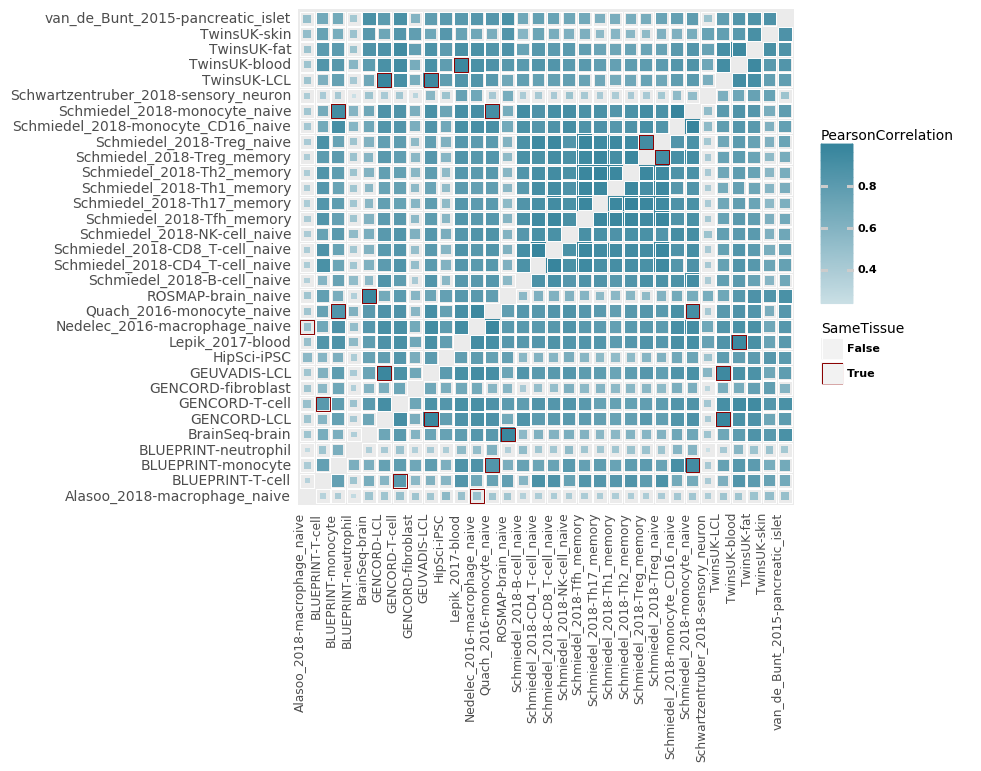

<ggplot: (2958969410856)>

In [460]:
((
ggplot(plot_data[plot_data['SameSample'] == False],aes(x='X',y='Y',fill='PearsonCorrelation'))+
    theme(
          legend_title=element_text(size=10),
#           legend_margin=margin(grid::unit(0,"cm")),
          legend_text=element_text(size=8,face="bold"),
#           legend_key_height=grid::unit(0_8,"cm"),
#           legend_key_width=grid::unit(0_2,"cm"),
          axis_title_x = element_blank(),
          axis_title_y = element_blank(),
          axis_text_x = element_text(angle = 90, vjust = 1, hjust=1),
          axis_text_y = element_text(size=10,vjust=0.2),
          axis_ticks = element_blank(),
          plot_background=element_blank(),
          plot_title=element_text(colour="grey20",hjust=0.1,vjust=-3,size=10,face="bold"),
          panel_border=element_blank(),
          panel_grid_major = element_blank(),
          panel_grid_minor = element_blank(),
          aspect_ratio = 1
    )+
    geom_tile(aes(height='PearsonCorrelation',width='PearsonCorrelation'))+
    scale_fill_gradient2(low = colour_low,mid=colour_mid,high = colour_high)+
    geom_tile(aes(color='SameTissue',height=0.9,width=0.9),fill=None,size=0.4)+
    scale_color_manual(['white','darkred'])
))